$\textbf{Introduction}$
In this section we will examine how well a simple feedforward network performs against a polynominal function for fitting very complex functions.  We will work with artificially-generated data.

$\textbf{Simple Example}$: Approximating a Sine and Exponential Function

In [1]:
# ! pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import matlab
import NNFFfunPkg
m = NNFFfunPkg.initialize()


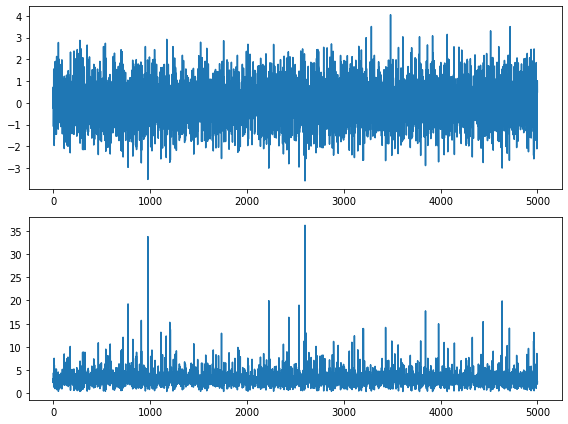

In [2]:
x = np.random.randn(5000)
y = np.cos(x)+ np.exp(-x)+ np.exp(x * .1);
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(8,6))
ax1.plot(x)
ax2.plot(y)
plt.tight_layout()

We see an apparantly random series generating data which exhibit several jump periods.  Suppose we do not know the true generating funciton?  How can be best fit the observed series to the exogenous observed series x?   First lets do a cubic polynomial fit.

In [5]:
x1=(x-min(x))/(max(x)-min(x))
y1=(y-min(y))/(max(y)-min(y))
pfit = np.polyfit(x1,y1,3)
yhat_poly = np.poly1d(pfit)(x1)
ehat =  y1 - yhat_poly;
RSQ_poly= 1 - ehat.var()/y1.var()
SSE_poly =  np.dot(y1-yhat_poly,y1-yhat_poly)
SSE_poly,RSQ_poly

(0.4099322503488955, 0.9099313415465782)

In [6]:
#normalizer = preprocessing.Normalization()
#normalizer.adapt(x)
#nn1=keras.Sequential([keras.layers.Dense(1,activation="relu"),keras.layers.Dense(1)])
#nn1.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='mse')
#nn1.summary()

nn1=keras.Sequential([keras.layers.InputLayer(input_shape=(1,)),keras.layers.Dense(3,activation="sigmoid"),keras.layers.Dense(1)])
nn1.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='mse')
nn1.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Epoch 1/80
79/79 [==============================] - 0s 460us/step - loss: 0.1442
Epoch 2/80
79/79 [==============================] - 0s 358us/step - loss: 0.0397
Epoch 3/80
79/79 [==============================] - 0s 384us/step - loss: 0.0080
Epoch 4/80
79/79 [==============================] - 0s 358us/step - loss: 0.0015
Epoch 5/80
79/79 [==============================] - 0s 358us/step - loss: 6.8430e-04
Epoch 6/80
79/79 [==============================] - 0s 358us/step - loss: 6.0905e-04
Epoch 7/80
79/79 [==============================] - 0s 358us/step - loss: 6.0296e-04
Epoch 8/80
79/79 [==============================] - 0s 358us/step - loss: 6.0031e-04
Epoch 9/80
79/79 [==============================] - 0s 371us/step - loss: 5.9762e-04
Epoch 10/80
79/79 [==============================] - 0s 371us/step - loss: 5.9457e-04
Epoch 11/80
79/79 [==============================] - 0s 371us/step - loss: 5.9151e-04
Epoch 12/80
79/79 [==============================] - 0s 358us/step - loss: 5.88

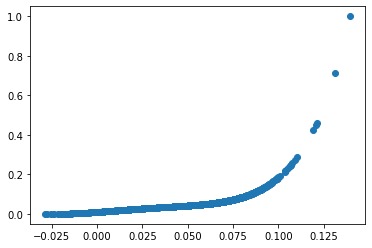

(2.0299735479056835, 0.9099313415465782)

In [7]:
history = nn1.fit(
    x1,
    y1,
    batch_size=64,
    epochs=80)

yhat_nn1 = nn1.predict(x1)
SSE_nn1 = len(y1)*nn1.evaluate(x1,y1,verbose=0)
ehat_nn1 =  y1 - yhat_nn1
RSQ_nn1 = 1 - ehat.var()/y1.var()

plt.scatter(yhat_nn1, y1, marker='o')
plt.show()
SSE_nn1, RSQ_nn1



In [15]:

nst = 2;
x2 = np.array(x1)
y2 = np.array(y1)
yhat_net = m.NNFFfun(x2,y2,2);

TypeError: unsupported Python data type: numpy.ndarray

SystemError: <built-in function evaluateFunction> returned NULL without setting an error

We see in this simple example that the Neural Net with two weighted log-sigmoid functions gives a better fit than the cubic polynomial expansion. Neural networks, even a simple shallow network with one hidden layer, is a more effective approximating function than cubic expansion.

$\textbf{Stochastic Chaos Model}$
The stochastic chaos model is useful for analyzing time-varying volatility.  It has the following form. where U represents the uniform distribution:

$y_{t} = 4 \xi_{t} y_{t-1}(1-y_{t-1})$

$\xi_{t} \sim U(0,1)$

$y_{0} = .5$
	 


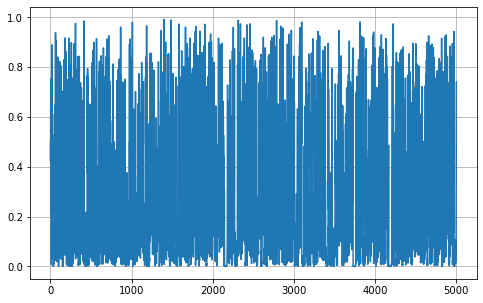

In [7]:
T = 5000
z = np.random.rand(T)
y=np.zeros(T)
y[0] = .5
for i in range(1,T):
    y[i] = 4 * z[i] * y[i-1] * (1-y[i-1])

plt.figure(figsize=(8,5))
plt.plot(y)
plt.grid()

In [8]:
def mlag(x,n=1,init=0):
    if len(x.shape)==1:
        x=x.reshape((-1,1))
    (nobs, nvar)=x.shape
    xlag=np.ones((nobs, nvar*n))*init
    for i in range(n):
        xlag[(i+1):,(i*nvar):((i+1)*nvar)]=np.roll(x,i+1,axis=0)[(i+1):]
    return xlag

In [9]:
# Lets forecast 
#Define the regressor as the lagged y variables
xx = mlag(y,4)[4:]
yy = y[4:]   # Define the dependent ariable as the next period variable.

#Create a 3rd order polynomial for all of the variables.  
poly=PolynomialFeatures(degree=3)
xx3=poly.fit_transform(xx)
clf=LinearRegression()
polyfit=clf.fit(xx3,yy)
RSQ_poly2=polyfit.score(xx3,yy)
SSE_poly2=np.dot(polyfit.predict(xx3)-yy,polyfit.predict(xx3)-yy)

In [10]:
SSE_poly2,RSQ_poly2

(159.41907955768858, 0.49112629153121723)

In [11]:
nn2=keras.Sequential([keras.layers.InputLayer(input_shape=(4,)),keras.layers.Dense(7,activation="sigmoid"),keras.layers.Dense(1)])
nn2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='mse')
nn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7)                 35        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________


In [12]:
history2=nn2.fit(xx,yy,epochs=50,verbose=0)
yhat_net2=nn2.predict(xx).flatten()
ehat_net2 = yy - yhat_net2
RSQ_net2= 1 - ehat_net2.var()/yy.var()
SSE_net2=len(yy)*nn2.evaluate(xx,yy,verbose=0)
SSE_net2,RSQ_net2

(188.39740966260433, 0.3986853229097791)

We see that the simple neural network gives the same performance with far fewer parameters than the cubic expansion. 35 parameters for the polynomial but for the neural net, 25 parameters for the first hidden layer (a constant and 4 lags for each of 5 neurons), plus weights and a constant for the 5 neurons, so we have 31 parameters. So neural nets rock, they economize on parameters.

In [13]:
normalizer=preprocessing.Normalization()
normalizer.adapt(xx)
nn3=keras.Sequential([normalizer,keras.layers.Dense(5,activation="sigmoid"),keras.layers.Dense(1)])
nn3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')
nn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 25        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 40
Trainable params: 31
Non-trainable params: 9
_________________________________________________________________


In [14]:
history3=nn3.fit(xx,yy,epochs=50,verbose=0)
yhat_net3=nn3.predict(xx).flatten()
ehat_net3 = yy - yhat_net3;
RSQ_net3= 1 - ehat_net3.var()/yy.var()
SSE_net3=len(yy)*nn3.evaluate(xx,yy,verbose=0)
SSE_net3,RSQ_net3

(163.77689696848392, 0.47755617282541185)

Normalization does not make that big of a difference for the swings in the data in this example.

$\textbf{Stochastic Volatility Jump Diffusion Model}$
This model has the following continuous time representation:

$((dS)/S) = (\mu-\lambda k)⋅dt+√V⋅dZ+k⋅dq $

$ dV  = (\alpha-\beta V)⋅dt+\sigma_{v}√V⋅dZ_{v}$ 

$ Corr(dZ,dZ_{v})  = \rho $

$ prob(dq  = 1)=\lambda dt $

$ ln(1+k) \sim \phi(ln[1+k]-.5 \kappa, \kappa^{2}) $



where dS/S is the rate of return on an asset, $\mu$ is the expected rate of appreciation, $\lambda$ the annual frequency of jumps, k the random percentage jump conditional on the jump occurring.  
The variable ln(1+k) is distributed normally with mean ln[1+k]-.5 $\kappa$  and variance $\kappa^{2}$.  The symbol $\phi$  represents the normal distribution. The advantage of the continuous-time representation is that the time interval can become arbitrarily smaller, and approximate "real time" changes.  

The instantaneous conditional variance V follows a mean-reverting square root process.  The parameter $\alpha$  is the mean of the conditional variance, while $\beta$ is the mean-reversion coefficient.  The coefficient $\sigma_{v}$ is the variance of the volatility process, while the noise terms dZ and $dZ_{v}$ are the standard continuous-time "white noise" Weiner processes, with correlation coefficient $\rho$.

This process has two major advantages.  First, it allows systematic volatility risk, and secondly, it generates an "analytically tractable method" for pricing options without sacrificing accuracy or unnecessary restrictions. 

$\underline{Parameters for SVJD Process}$	
Mean Return	$\mu$	.21

Mean volatility	$\alpha$	.0003

Mean reversion of volatility	$\beta$	.7024

Time interval (daily)	dt	1/250

Expected jump	k	.3

Standard deviation of percentage jump	$\kappa$	.0281

Annual frequency of jumps	$\lambda$	2

Correlation of Weiner processes	$\rho$	.6


In this model, $S_{t+1}$ is equal to $S_{t}+[S_{t}⋅(\mu-\lambda k)] ⋅dt$, and for a small value of dt,  it will be unit-root nonstationary.  
After first-differencing, the model will be driven by the components of dV and k⋅dq, which are random terms.  
We should not expect the linear or neural network model to do particularly well.  Put another way, we should be suspicious if the network model significantly outperformed a rather poor linear model. 

In [15]:
def svjdprocess(beta,hh,rr):
    alpha,beta,delta,kbar,lam,mu,sigmav,rho=beta
    if beta > 1: beta = .95
    if lam > 4: lam = 4
    h=1/hh
    poissz=np.random.poisson(lam*h,rr)
    z = np.random.randn(rr)
    zk = np.random.randn(rr)
    zv=rho*z+np.random.randn(rr)*np.sqrt(1-rho**2)
    k=np.zeros(rr)
    v=np.ones(rr)*0.00001
    yhat=np.zeros(rr)
    
    for i in range(1,rr):
        k[i] =  zk[i]* delta + np.log(1+kbar) - .5 * delta**2
        yhat[i] = (mu - lam * kbar) * h + np.sqrt(v[i-1]) * z[i]+ k[i] * poissz[i]
        v[i] = v[i-1] + (alpha - beta * v[i-1]) * h + sigmav * np.sqrt(v[i-1]) *zv[i]
        if v[i]<0:v[i]=0.001
    return yhat
    

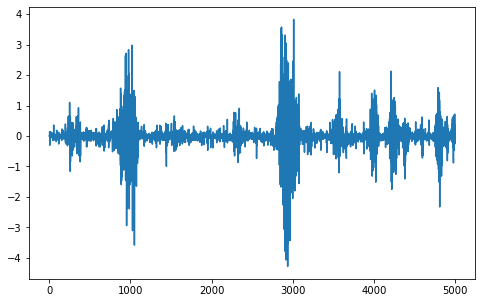

In [16]:
# beta(1)=alpha
# beta(2) = beta
# beta(3) = delta
#  beta(4) = kbar
#  beta(5) = lambda
#  beta(6) = mu
#  beta(7) = sigmav
#  beta(8) = rho

hh = 250
T = 5000
betab = [.0003,.7024, .0281 ,.30, 2 ,.2133 ,.1179, .6]
yhat = svjdprocess(betab,hh,T)
plt.figure(figsize=(8,5))
plt.plot(yhat);

In [17]:
xx1=mlag(yhat,4)[4:]
yy1=yhat[4:]

poly1=PolynomialFeatures(degree=5)
xx5=poly1.fit_transform(xx1)
polyfit1=clf.fit(xx5,yy1)
RSQ_poly3=polyfit1.score(xx5,yy1)
SSE_poly3=np.dot(polyfit1.predict(xx5)-yy1,polyfit1.predict(xx5)-yy1)

In [18]:
SSE_poly3,RSQ_poly3

(735.8950004495814, 0.24213798627289929)

With the polynomial with 5th order expansion, we have 126 coefficients, $R^{2}$ = .1237.

In [29]:
normalizer=preprocessing.Normalization()
normalizer.adapt(xx1)
nn4=keras.Sequential([normalizer,keras.layers.Dense(19,activation="sigmoid"),keras.layers.Dense(1)])
nn4.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),loss='mse')
nn4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_14 (Dense)             (None, 19)                95        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 20        
Total params: 124
Trainable params: 115
Non-trainable params: 9
_________________________________________________________________


In [30]:
history4=nn4.fit(xx1,yy1,epochs=100,verbose=0)
yhat_net4=nn4.predict(xx1).flatten()
ehat_net4 =  yy1 - yhat_net4
RSQ_net4= 1 - ehat_net4.var()/yy1.var()
SSE_net4=len(yy1)*nn4.evaluate(xx1,yy1,verbose=0)
SSE_net4,RSQ_net4

(958.6624948978424, 0.01284823403651214)

With the neural net, we have 115 parameters for 19 neurons with 4 lags, with an $R^{2}$ of .61.  So again the neural net outperforms the polynomial expansion.